In [1]:
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from skimage.transform import resize
from skimage.color import rgb2gray
class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)        
        self.img_size = (64, 64, 1)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _observation(self, img):
        img = img[50:200, 10:140, :]
        img = resize(img, (64, 64, 3), mode='constant')
        img = rgb2gray(img)
        return img[:,:,np.newaxis].astype('float32')

In [4]:
import gym
env = gym.make("BreakoutDeterministic-v0") 

In [5]:
env.reset()
s, _, _, _ = env.step(0)

## Пример обрезки изображения

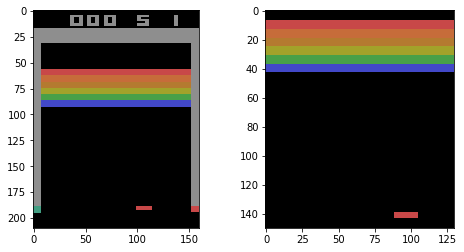

In [6]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(s)
plt.subplot(1,2,2)
plt.imshow(s[50:200, 10:140, :])

(64, 64, 1)
<class 'numpy.ndarray'>
Formal tests seem fine. Here's an example of what you'll get.


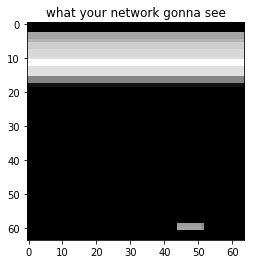

In [7]:
env = gym.make("BreakoutDeterministic-v0") #create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

print(obs.shape)
print(type(obs))
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"

assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');


In [8]:
from framebuffer import FrameBuffer
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

In [9]:
state_dim

(4, 64, 64)

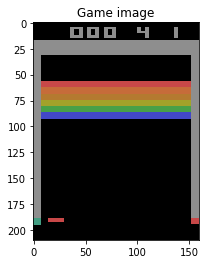

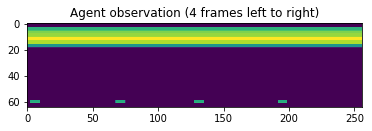

In [10]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(np.hstack([obs[0], obs[1], obs[2], obs[3]]))

In [11]:
def evaluate(env, model, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    num_actions = env.action_space.n
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            action = epsilon_greedy_act(s[np.newaxis], num_actions, model, 0)
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

## Архитектура сети

In [12]:
import numpy as np

In [13]:
500*5000/10e6

0.25

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter

In [26]:
from helpers.replay_buffer import ReplayBuffer
from helpers.shedules import LinearSchedule
from helpers.create_empty_directory import create_empty_directory

In [27]:
import copy
from IPython.display import clear_output


In [17]:
use_cuda = torch.cuda.is_available()

In [18]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
def convert_to_var(arr, astype='float32', add_dim=False):
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [19]:
class DQNnet(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.conv_net = nn.Sequential(
                            nn.Conv2d(in_channels=4, out_channels=16, 
                                      stride=2, kernel_size=3,
                                      ),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=16, out_channels=32, 
                                      stride=2, kernel_size=3,
                                      ),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=32, out_channels=64, 
                                      stride=2, kernel_size=3,
                                      ),
                            nn.ReLU()
                            )
        self.fc_net = nn.Sequential(
                            nn.Linear(64*7*7, 512),
                            nn.ReLU(),
                            nn.Linear(512, num_actions),
                            )
    def forward(self, x):
        conv_out = self.conv_net(x)
        out = self.fc_net(conv_out.view(-1, 64*7*7))
        return out

In [20]:
def optimize_dqn_loss(optimizer, model, target_model, batch, gamma,
                      target_type='double_q_learning', tau=None, double_dqn=True,
                     ):

    states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = batch
    states_batch_var = convert_to_var(states_batch)
    actions_batch_var = convert_to_var(actions_batch[:, np.newaxis], astype='int64')
    rewards_batch_var = convert_to_var(rewards_batch)
    next_states_batch_var = convert_to_var(next_states_batch)
    dones_batch_var = convert_to_var(dones_batch)
    q_values = model.forward(states_batch_var).gather(1, actions_batch_var)

    if target_type == 'standard_q_learning':
        next_q_values = target_model.forward(next_states_batch_var).detach()
        best_next_q_values = next_q_values.max(dim=1)[0]
        best_next_q_values[dones_batch_var.byte()] = 0
        q_values_targets = rewards_batch_var + gamma * best_next_q_values

    elif target_type == 'double_q_learning':
        all_next_q_values = target_model.forward(next_states_batch_var).detach()
        argmax = torch.max(model.forward(next_states_batch_var), dim=1)[1]
        best_next_q_values = all_next_q_values.gather(1, argmax.view((-1, 1)))[:,0]
        best_next_q_values[dones_batch_var.byte()] = 0
        q_values_targets = rewards_batch_var + gamma * best_next_q_values

    mse_loss_func = nn.MSELoss()
    loss = mse_loss_func(q_values, q_values_targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.data[0]
    
    
def epsilon_greedy_act(state, num_actions, model, eps_t):
    state_var = convert_to_var(state)
    q_values = model.forward(state_var).data.numpy()[0]
    if np.random.rand() < eps_t:
        action = np.random.randint(num_actions)
    else:
        action = q_values.argmax()
    return action


In [21]:
from datetime import  datetime

In [31]:
batch_size = 64

def train(env,
          eps_greedy_exploration_params,
          gamma=0.99,
          max_steps=int(10e6),
          learning_starts_in_steps=5000,
          train_freq_in_steps=10,
          update_freq_in_steps=5000,
          plot_freq_in_steps=1000,
          seed=None,
          lr=1e-4
          ):
    if seed:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    num_actions = env.action_space.n
    dim_states = env.observation_space.shape[0]

    # define models
    model = DQNnet(num_actions)
    target_model = copy.deepcopy(model)
    
    # define optimizator
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # define shedule of epsilon in epsilon-greedy exploration
    schedule_timesteps=int(eps_greedy_exploration_params['exploration_fraction']*max_steps)
    eps_shedule = LinearSchedule(schedule_timesteps=schedule_timesteps,
                                 initial_p=1.0,
                                 final_p=eps_greedy_exploration_params['exploration_final_eps'])
    folder = 'logs/breakout'
    create_empty_directory(folder)
    writer = SummaryWriter(folder)
    
    replay_buffer = ReplayBuffer(100000, seed=seed)
    num_episodes = 0
    episode_rew = 0
    episode_rewards = []
    evaluations=[]
    losses=[]
    state = env.reset()
    
    t_start = datetime.now()
    
    for t in range(max_steps):
        eps_t = eps_shedule.value(t)
        writer.add_scalar('dqn/eps_t', eps_t, t)
        
        action = epsilon_greedy_act(state[np.newaxis], num_actions, model, eps_t)
        writer.add_scalar('dqn/action_t', action, t)
        next_state, rew, done, _ = env.step(action)
        episode_rew += rew
        replay_buffer.add(state, action, rew, next_state, done)
        state = next_state
        
        if done:
            num_episodes += 1
            episode_rewards.append(episode_rew)
            writer.add_scalar('dqn/episode_rew', episode_rew, num_episodes)
            episode_rew=0
            state = env.reset()

        if t >= learning_starts_in_steps and t % train_freq_in_steps == 0:
            batch = replay_buffer.sample(batch_size)
            loss = optimize_dqn_loss(optimizer, model, target_model, batch, gamma,
                                    target_type='standard_q_learning')
            losses.append(loss)
            writer.add_scalar('dqn/loss_t', loss, t)
        else:
            loss = 0
            
        if t > learning_starts_in_steps and t % update_freq_in_steps == 0:
            target_model = copy.deepcopy(model)
            
        if t % 1000 == 0:            
            clear_output(True)
            time_in_minutes = (datetime.now() - t_start).total_seconds()/60
            print("time passed %.2f minutes"%time_in_minutes)
            print("t = %i, num episode=%i, epsilon = %.5f" % (t, num_episodes, eps_t))
            print("Mean rewards per last 100 episodes: %.1f" % np.mean(episode_rewards[-100:]))
            
            plt.figure(figsize=[12, 4])
            plt.subplot(1,2,1)
            plt.title("mean reward per episode")
            plt.plot(episode_rewards)
            plt.grid()

            assert not np.isnan(loss)
            plt.figure(figsize=[12, 4])
            plt.subplot(1,2,2)
            plt.title("TD loss history (moving average)")
            plt.plot(pd.ewma(np.array(losses), span=100, min_periods=100))
            plt.grid()
            plt.show()

In [32]:
eps_greedy_exploration_params = {'exploration_fraction': 0.25,
                                 'exploration_final_eps': 0.1}

In [33]:
schedule_timesteps=int(eps_greedy_exploration_params['exploration_fraction']*10**6)
eps_shedule = LinearSchedule(schedule_timesteps=schedule_timesteps,
                             initial_p=1.0,
                             final_p=eps_greedy_exploration_params['exploration_final_eps'])


time passed 41.81 minutes
t = 96000, num episode=544, epsilon = 0.96544
Mean rewards per last 100 episodes: 1.0


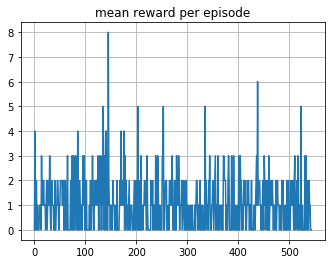

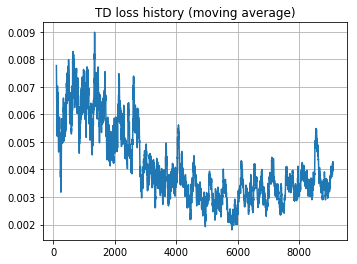

In [ ]:
train(make_env(), eps_greedy_exploration_params)

In [ ]:
53000-6.18